In [10]:
import torch
import numpy as np
from PIL import Image
import torch.nn as nn
import os
from catboost import CatBoostClassifier

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(),  
            nn.MaxPool2d(2),
            
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),  
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            
            nn.Flatten(), 
            nn.Dropout(0.5), 
            nn.Linear(64 * 6 * 6, 256), nn.BatchNorm1d(256), nn.ReLU(), 
            nn.Dropout(0.5),
            nn.Linear(256, 7), 
        )
    
    def forward(self, x):
        return self.net(x)

checkpoint = torch.load("../best_models/model_checkpoint_60.62.pth")
model = CNN()
model.load_state_dict(checkpoint)
model.eval()
classes = list(os.listdir('../data/train'))

catboost_model = CatBoostClassifier()
catboost_model.load_model('../best_models/catboost_model.cbm') 

C:\Users\Dmitry\AppData\Local\Temp\ipykernel_36164\1285168252.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("../best_models/model_checkpoint_6

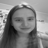

CNN: sad (34.13%)
CatBoost: happy (55.33%)


C:\Users\Dmitry\AppData\Local\Temp\ipykernel_36164\4271670898.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"CatBoost: {classes[int(cb_pred[0])]} ({cb_conf:.2%})")


In [17]:
def predict_photo(image_path):
    img = Image.open(image_path).convert('L').resize((48, 48))
    display(img) 
    img_array = np.array(img, dtype=np.float32) / 255.0
    img_tensor = torch.from_numpy(img_array).unsqueeze(0).unsqueeze(0)
    with torch.no_grad():
        # CNN
        cnn_output = model(img_tensor)
        cnn_probs = torch.nn.functional.softmax(cnn_output, dim=1)
        cnn_conf, cnn_pred = torch.max(cnn_probs, 1)
        
        # CatBoost
        img_flat = img_array.flatten().reshape(1, -1)
        cb_pred = catboost_model.predict(img_flat) 
        cb_proba = catboost_model.predict_proba(img_flat)
        cb_conf = np.max(cb_proba)
    
    print(f"CNN: {classes[cnn_pred.item()]} ({cnn_conf.item():.2%})")
    print(f"CatBoost: {classes[int(cb_pred[0])]} ({cb_conf:.2%})")

predict_photo("../my_photo.jpg")

Ожидалось happy btw..

In [21]:
def predict_all(image_path):
    img = Image.open(image_path).convert('L').resize((48, 48))
    img_array = np.array(img, dtype=np.float32) / 255.0
    # CNN
    img_tensor = torch.from_numpy(img_array).unsqueeze(0).unsqueeze(0)
    with torch.no_grad():
        cnn_probs = torch.softmax(model(img_tensor), dim=1)[0]
    print("CNN:")
    for i, em in enumerate(classes):
        print(f" {em}: {100*cnn_probs[i]:.2f}%")


    # CatBoost
    cb_probs = catboost_model.predict_proba(img_array.reshape(1, -1))[0]
    print("\nCatBoost:")
    for i, em in enumerate(classes):
        print(f" {em}: {100*cb_probs[i]:.2f}%")

predict_all("../my_photo.jpg")

CNN:
 angry: 8.24%
 disgust: 0.08%
 fear: 8.19%
 happy: 14.64%
 neutral: 33.62%
 sad: 34.13%
 surprise: 1.09%

CatBoost:
 angry: 13.32%
 disgust: 0.53%
 fear: 10.98%
 happy: 55.33%
 neutral: 6.42%
 sad: 12.42%
 surprise: 0.99%
